# Explainability for PyTorch Models

This notebook contains work done for replicating part of the paper "Sanity Checks for Saliency Maps" by Adebayo et al. It entails:
1. Loading a trained PyTorch model
2. Using a python package to return the GradCAM result for a given input tensor
3. Apply the "Cascading Randomization" technique from the above paper
4. Test the results using the same metrics as the above paper.


For the gradcam implementation, we use 
```
@misc{jacobgilpytorchcam,
  title={PyTorch library for CAM methods},
  author={Jacob Gildenblat and contributors},
  year={2021},
  publisher={GitHub},
  howpublished={\url{https://github.com/jacobgil/pytorch-grad-cam}},
}
```

In [1]:
# TORCH implementation of load_data
import os
import numpy as np
import pickle
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader


In [2]:
from scr.pytorch_model_defs import WaterPlasticModel

In [3]:
# Load the data
from scr.pytorch_data_loaders import load_data_from_directory, ImageDataset

In [4]:
# # Paths to your data directories
# train_dir = "data/classification_dataset/train"
# validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# # Load the data
# train_images, train_labels = load_data_from_directory(train_dir)
# val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)

# train_dataset = ImageDataset(train_images, train_labels, transform=None)
# val_dataset = ImageDataset(val_images, val_labels, transform=None)
test_dataset = ImageDataset(test_images, test_labels, transform=None)



In [5]:
test_dataset

In [6]:
BATCH_SIZE = 32
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,      # Typically no shuffle for test
    num_workers=2,
    pin_memory=True
)

# GradCAM

In [7]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt


tensor(1)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

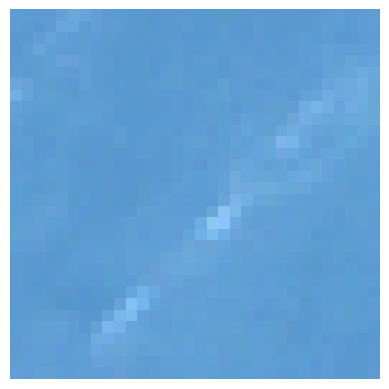

In [86]:
for images, labels in test_loader:
    input_tensor = images
    labels = labels
    break

print(labels[0])
rgb_image = input_tensor[0, :][[3,2,1], :, :]
rgb_image = rgb_image.permute(1,2,0).numpy()
plt.imshow((rgb_image / np.max(rgb_image) * 255).astype(np.uint8))
plt.axis('off')
# plt.imshow((rgb_image / np.max(rgb_image) * 255).astype(np.uint8))

In [9]:
labels

tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 0, 0, 0])

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

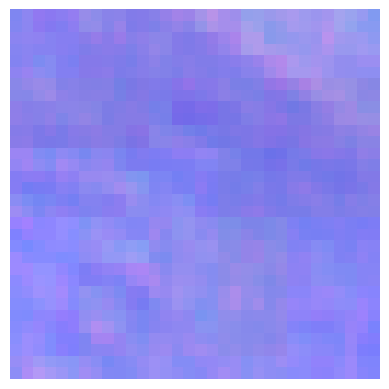

In [10]:
nir_image = input_tensor[0, :][[8,3,2], :, :]
nir_image = nir_image.permute(1,2,0).numpy()
plt.imshow((nir_image / np.max(nir_image) * 255).astype(np.uint8))
plt.axis('off')

In [87]:
model = torch.load('models/pytorch_models/100_epochs_classweights_augmentations.pth', weights_only=False)

In [88]:
target_layers = [model.conv3]
# target_layers = [model.conv2]
# target_layers = [model.conv1]

cam = GradCAM(model=model, target_layers=target_layers)

In [89]:
print(f"True Label: {labels[0]}")

True Label: 1


In [90]:
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]

In [91]:
water_grayscale_cam = cam(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam = cam(input_tensor=input_tensor, targets=plastic_target)

In [92]:
# In this example grayscale_cam has only one image in the batch:
water_visualization = show_cam_on_image(rgb_image, water_grayscale_cam[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization = show_cam_on_image(rgb_image, plastic_grayscale_cam[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

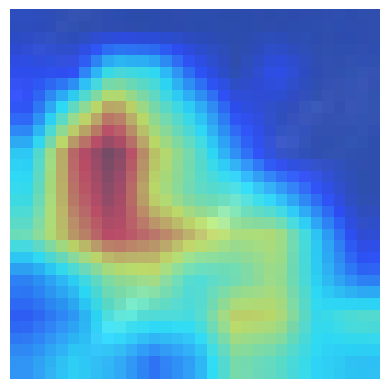

In [93]:
plt.imshow(water_visualization)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

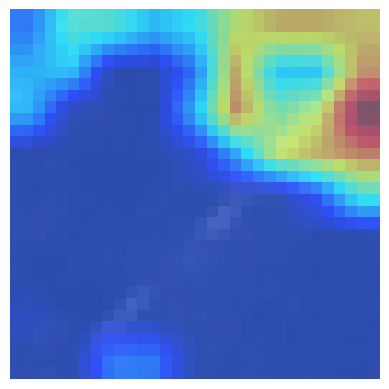

In [94]:
plt.imshow(plastic_visualization)
plt.axis('off')

In [95]:
import torch.nn.init as init

# Randomize Layers from top to bottom

## FC2

In [96]:
with torch.no_grad():
    init.kaiming_normal_(model.fc2.weight, nonlinearity='relu')
    if model.fc2.bias is not None:
        init.constant_(model.fc2.bias, 0)

In [97]:
cam_fc2 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_fc2 = cam_fc2(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_fc2 = cam_fc2(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_fc2 = show_cam_on_image(rgb_image, water_grayscale_cam_fc2[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_fc2 = show_cam_on_image(rgb_image, plastic_grayscale_cam_fc2[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

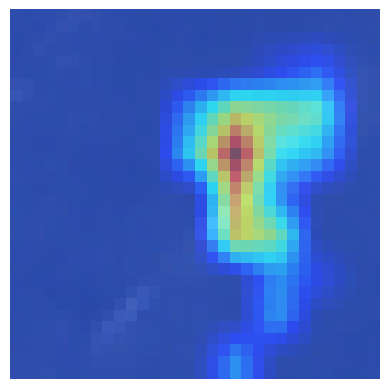

In [98]:
plt.imshow(water_visualization_fc2)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

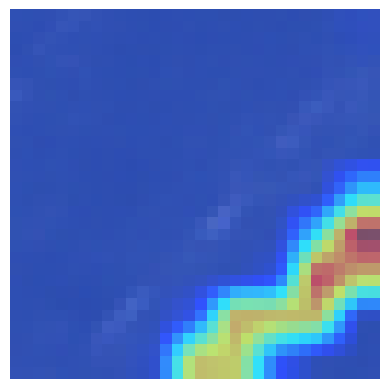

In [99]:
plt.imshow(plastic_visualization_fc2)
plt.axis('off')

## FC1?

In [100]:
with torch.no_grad():
    init.kaiming_normal_(model.fc1.weight, nonlinearity='relu')
    if model.fc1.bias is not None:
        init.constant_(model.fc1.bias, 0)


In [101]:
cam_fc1 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_fc1 = cam_fc1(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_fc1 = cam_fc1(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_fc1 = show_cam_on_image(rgb_image, water_grayscale_cam_fc1[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_fc1 = show_cam_on_image(rgb_image, plastic_grayscale_cam_fc1[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

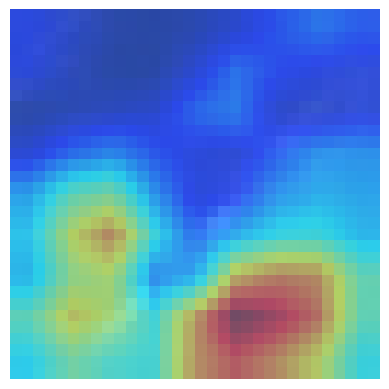

In [102]:
plt.imshow(water_visualization_fc1)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

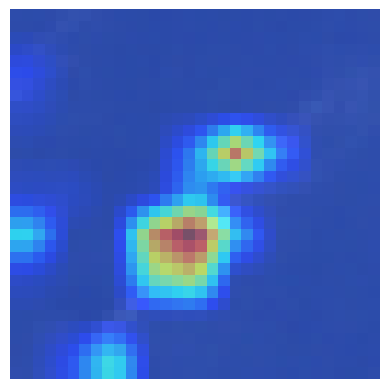

In [103]:
plt.imshow(plastic_visualization_fc1)
plt.axis('off')

## Randomize Conv3

In [104]:
# Assuming 'model' is your trained model and 'conv3' is the layer to reinitialize
with torch.no_grad():
    init.kaiming_normal_(model.conv3.weight, nonlinearity='relu')
    if model.conv3.bias is not None:
        init.constant_(model.conv3.bias, 0)



In [105]:
cam_conv3 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_conv3 = cam_conv3(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_conv3 = cam_conv3(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_conv3 = show_cam_on_image(rgb_image, water_grayscale_cam_conv3[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_conv3 = show_cam_on_image(rgb_image, plastic_grayscale_cam_conv3[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

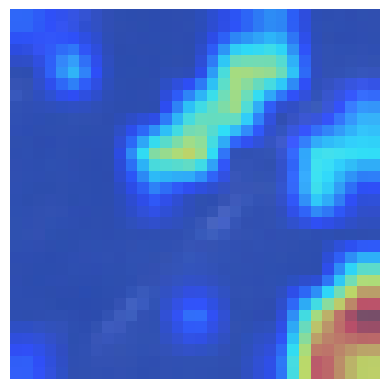

In [106]:
plt.imshow(water_visualization_conv3)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

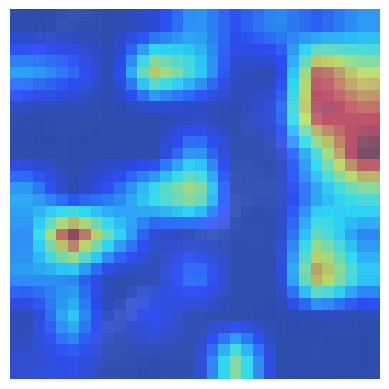

In [107]:
plt.imshow(plastic_visualization_conv3)
plt.axis('off')

## Randomize Conv2

In [108]:
with torch.no_grad():
    init.kaiming_normal_(model.conv2.weight, nonlinearity='relu')
    if model.conv2.bias is not None:
        init.constant_(model.conv2.bias, 0)


In [109]:
cam_conv2 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_conv2 = cam_conv2(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_conv2 = cam_conv2(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_conv2 = show_cam_on_image(rgb_image, water_grayscale_cam_conv2[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_conv2 = show_cam_on_image(rgb_image, plastic_grayscale_cam_conv2[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

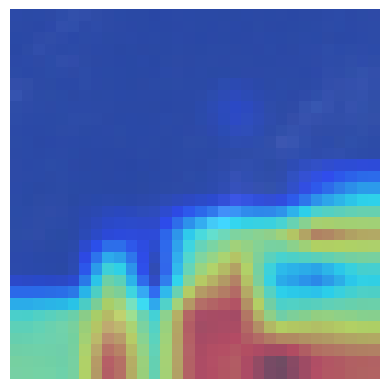

In [110]:
plt.imshow(water_visualization_conv2)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

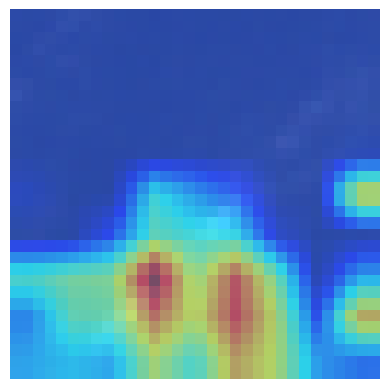

In [111]:
plt.imshow(plastic_visualization_conv2)
plt.axis('off')

## Randomize conv1

In [112]:
with torch.no_grad():
    init.kaiming_normal_(model.conv1.weight, nonlinearity='relu')
    if model.conv1.bias is not None:
        init.constant_(model.conv1.bias, 0)


In [113]:
cam_conv1 = GradCAM(model=model, target_layers=target_layers)
# targets = [ClassifierOutputTarget(0), ClassifierOutputTarget(1)]
water_target = [ClassifierOutputTarget(0)]
plastic_target = [ClassifierOutputTarget(1)]
water_grayscale_cam_conv1 = cam_conv1(input_tensor=input_tensor, targets=water_target)
plastic_grayscale_cam_conv1 = cam_conv1(input_tensor=input_tensor, targets=plastic_target)
# In this example grayscale_cam has only one image in the batch:
water_visualization_conv1 = show_cam_on_image(rgb_image, water_grayscale_cam_conv1[0, :], use_rgb=True, image_weight=0.9)
plastic_visualization_conv1 = show_cam_on_image(rgb_image, plastic_grayscale_cam_conv1[0, :], use_rgb=True, image_weight=0.9)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

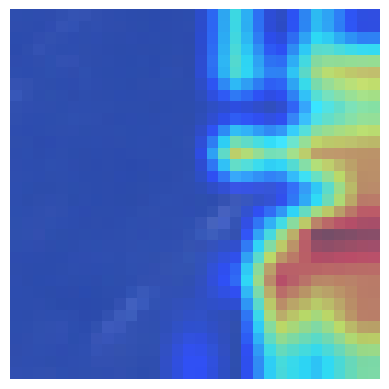

In [114]:
plt.imshow(water_visualization_conv1)
plt.axis('off')

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

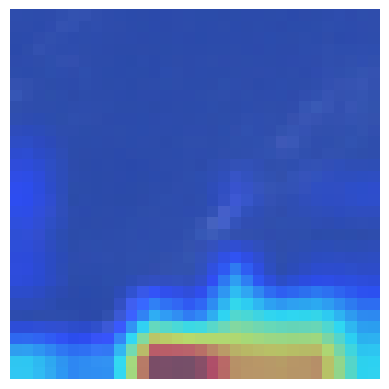

In [115]:
plt.imshow(plastic_visualization_conv1)
plt.axis('off')

# Non-Visual Metrics

In [116]:
from scr.similarity_metrics import spearman_rank_correlation_abs, spearman_rank_correlation_noabs, structural_similarity_index, pearson_correlation_hog

In [117]:
# # The explanation of the trained model
# trained_saliency_maps = [plastic_visualization]
# # Explanations from the cascading randomizations
# randomized_saliency_maps = [
#     plastic_visualization,
#     plastic_visualization_fc2,
#     plastic_visualization_fc1,
#     plastic_visualization_conv3,
#     plastic_visualization_conv2,
#     plastic_visualization_conv1,
# ]

# The explanation of the trained model
trained_saliency_maps = [plastic_grayscale_cam[0,:]]
# Explanations from the cascading randomizations
randomized_saliency_maps = [
    plastic_grayscale_cam[0,:],
    plastic_grayscale_cam_fc2[0,:],
    plastic_grayscale_cam_fc1[0,:],
    plastic_grayscale_cam_conv3[0,:],
    plastic_grayscale_cam_conv2[0,:],
    plastic_grayscale_cam_conv1[0,:],
]



In [118]:
def compute_metrics(original_map, randomized_map):
    # 1) Spearman Rank Correlation (absolute values)
    abs_spearman = spearman_rank_correlation_abs(original_map, randomized_map)
    
    # 2) Spearman Rank Correlation (signed / diverging)
    signed_spearman = spearman_rank_correlation_noabs(original_map, randomized_map)
    
    # 3) SSIM
    ssim_val = structural_similarity_index(original_map, randomized_map)
    
    # 4) Pearson Correlation of HOGs
    hog_corr = pearson_correlation_hog(original_map, randomized_map)
    
    return abs_spearman, signed_spearman, ssim_val, hog_corr

# Compare the sets of saliency maps
all_metrics = {
    "Spearman Absolute Value": [],
    "Signed Spearman": [],
    "Structural Similarity Index": [],
    "HOG Pearson Correlation": []
}
for i in range(len(randomized_saliency_maps)):
    original_map = trained_saliency_maps[0]
    rand_map = randomized_saliency_maps[i]
    abs_spearman, signed_spearman, ssim_val, hog_corr = compute_metrics(original_map, rand_map)
    all_metrics["Spearman Absolute Value"].append(abs_spearman)
    all_metrics["Signed Spearman"].append(signed_spearman)
    all_metrics["Structural Similarity Index"].append(ssim_val)
    all_metrics["HOG Pearson Correlation"].append(hog_corr)


In [119]:
all_metrics

{'Spearman Absolute Value': [np.float64(1.0),
  np.float64(-0.2302556937240478),
  np.float64(-0.23408321489957576),
  np.float64(0.23306398154051378),
  np.float64(-0.628695731677873),
  np.float64(-0.4612699893496564)],
 'Signed Spearman': [np.float64(1.0),
  np.float64(-0.2302556937240478),
  np.float64(-0.23408321489957576),
  np.float64(0.23306398154051378),
  np.float64(-0.628695731677873),
  np.float64(-0.4612699893496564)],
 'Structural Similarity Index': [np.float64(1.0),
  np.float64(0.2104285225226692),
  np.float64(0.12608644882260714),
  np.float64(0.007363457991183846),
  np.float64(0.0014010196321349014),
  np.float64(0.13772234616453244)],
 'HOG Pearson Correlation': [np.float32(0.99999994),
  np.float32(-0.06229703),
  np.float32(-0.08310115),
  np.float32(-0.10275875),
  np.float32(-0.091030255),
  np.float32(-0.023630962)]}

In [120]:
cascading_labels = ["Original","Fc2", "Fc1", "Conv3", "Conv2", "Conv1"]

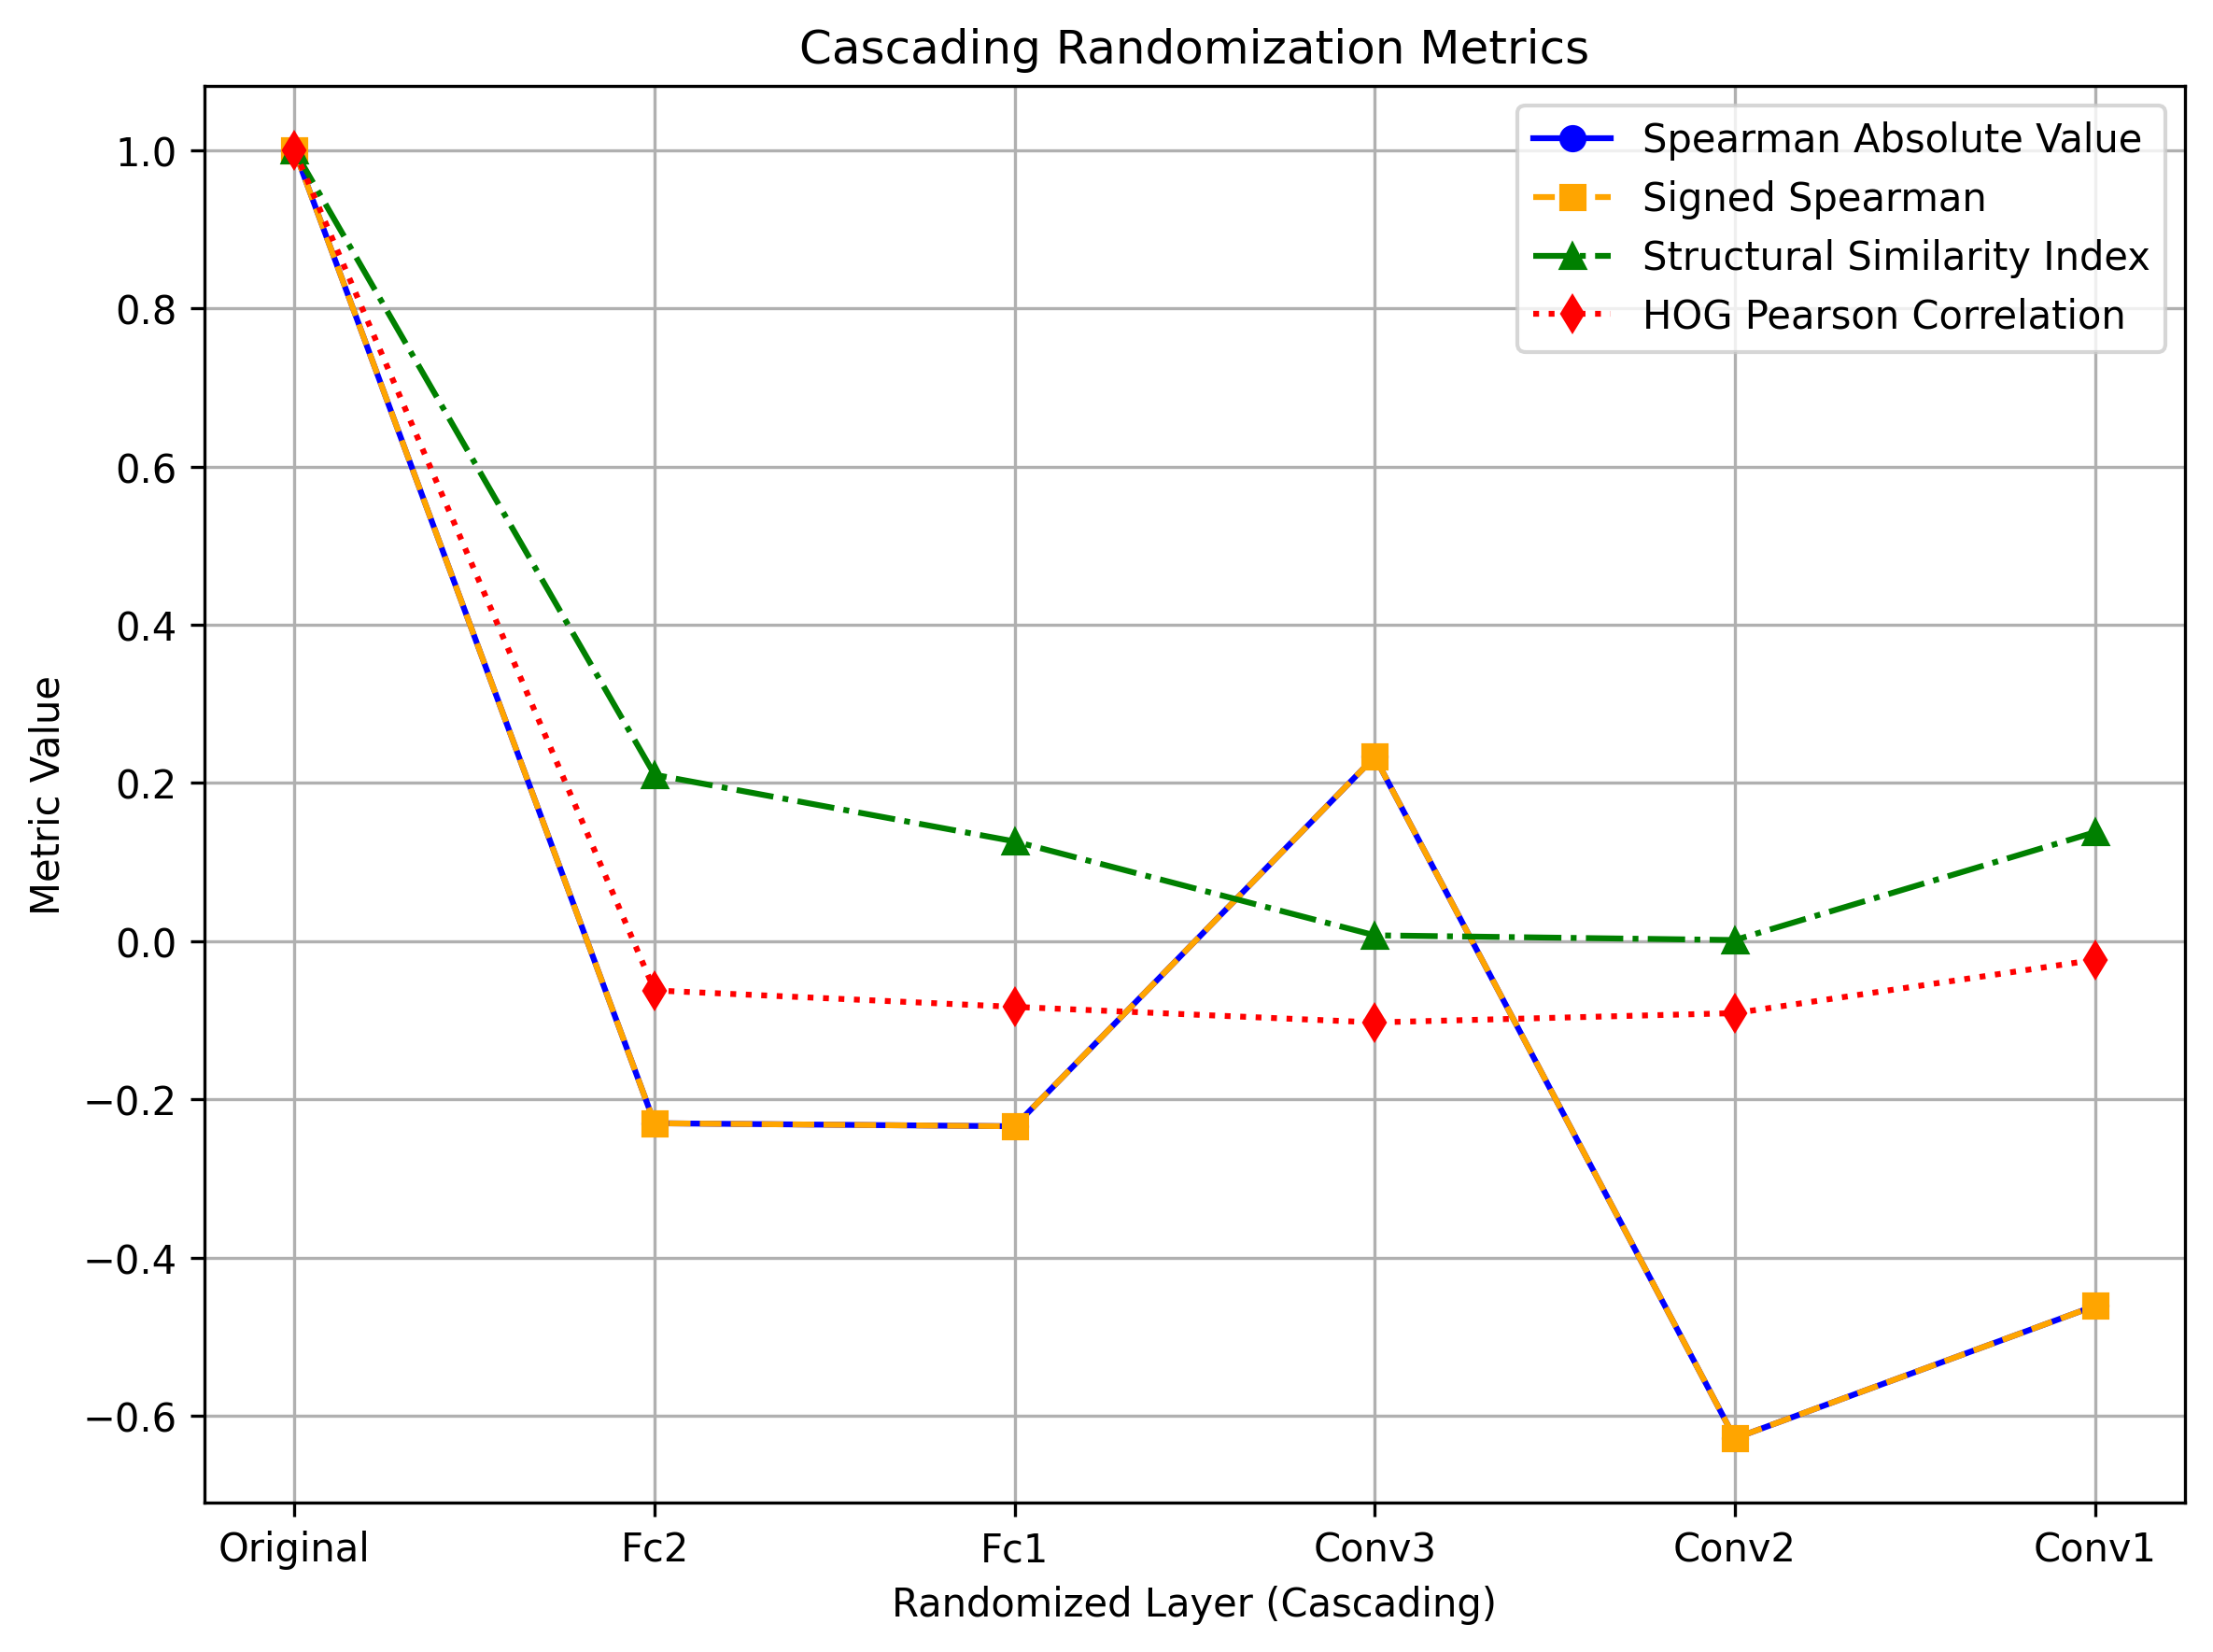

In [121]:
line_styles = ['o-', 's--', '^-.', 'd:']  # one style per metric
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(8, 6), dpi=300)

# Plot each metric on the same axes
for (metric_name, metric_values), style, color in zip(all_metrics.items(),
                                                      line_styles, 
                                                      colors):
    plt.plot(cascading_labels, metric_values, style, color=color,
             label=metric_name)

plt.xlabel("Randomized Layer (Cascading)")
plt.ylabel("Metric Value")
plt.title("Cascading Randomization Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()